In [88]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt
from functools import partial

In [138]:
@jit
def stieltjes_inversion(s):
    return 1 / jnp.pi * jnp.imag(s) / d

def plot_spectra(Khat_eigs, limit_dist=None, y_log=True, left_limit=6):
    hist, bins = jnp.histogram(Khat_eigs[Khat_eigs > 0], bins=100)
    logbins = np.logspace(-left_limit,np.log10(bins[-1]),len(bins))
    plt.hist(Khat_eigs, bins=logbins, density=True)
    plt.xscale("log")
    if limit_dist is not None:
        plt.plot(xvals, limit_dist)
    if y_log:
        plt.yscale("log")

In [135]:
class SpikedRF():
    def __init__(self,v,d,alpha,beta,tau):
        self.v = v
        self.d = d
        self.alpha = alpha
        self.beta = beta
        self.tau = tau

        indices_vec = jnp.arange(self.v*1.0) + 1
        self.b = jnp.power(indices_vec,-self.beta)
        self.a = jnp.power(indices_vec,-self.alpha-self.beta)
        self.D_vec = jnp.power(indices_vec,-2*self.alpha)

    def empirical_spectrum(self,n_sims,seed=0):
        key = random.key(seed)
        sqrt_D = jnp.diag(jnp.sqrt(self.D_vec))
        one = jnp.ones(shape=(d,))
        Khat_eigs = jnp.zeros((self.v,))

        for _ in range(n_sims):
            key, Z_key = random.split(key)
            Z = random.normal(Z_key, shape=(self.v,self.d)) / jnp.sqrt(self.d)

            W = self.tau * self.d**(self.beta-1/2) * jnp.outer(self.b,one) + Z

            Khat = sqrt_D @ W @ W.T @ sqrt_D
            Khat_eigs += jnp.linalg.eigvalsh(Khat)

        return Khat_eigs / n_sims

    @partial(jit, static_argnums=0)
    def hachem_fp_step(z,s,t):
        S_vec = 1/(1+(s/self.d)*self.D_vec)
        bSb = jnp.sum(S_vec * (self.a**2))
        u = 1/(1 + t/self.d)
        denom = 1-self.tau**2/z * self.d**(2*self.beta) * u * bSb

        s = -self.d/z * u - (self.tau**2/z**2 * self.d**(2*self.beta) * u**2 * bSb)/denom
        t = -jnp.sum(self.D_vec * S_vec)/z - (self.tau**2 * self.d**(2*self.beta)/z**2 * \
            u * jnp.sum(self.D_vec * S_vec**2 * a**2))/denom

        return s,t    

    @partial(jit, static_argnums=0) 
    def hachem_fp_solve(x,ivals):
        s = 1
        t = 1
        for i in ivals:
            z = x + i*1.0j
            s,t = hachem_fp_step(z,s,t,self.tau)

        return s,t

    @partial(jit, static_argnums=0)
    def hachem_limit_dist_x(self,x,ivals):
        s,t = hachem_fp_solve(x,ivals,self.tau)
        S_vec = 1/(1+(s/self.d)*self.D_vec)
        bSb = jnp.sum(S_vec * (self.a**2))
        u = 1/(1 + t/self.d)
        denom = 1-self.tau**2/z * self.d**(2*self.beta) * u * bSb
        tr_R = -1/z * jnp.sum(S_vec) - (self.tau**2/z**2 * self.d**(2*self.beta) * u * jnp.sum(S_vec**2 * self.a**2))/denom

        return stieltjes_inversion(tr_R)

    def hachem_limit_dist(self,xvals,ivals):
        limit_dist = []
        for x in xvals:
            limit_dist.append(self.hachem_limit_dist_x(x,ivals).reshape(-1))

        return jnp.array(limit_dist)

    @partial(jit, static_argnums=0)
    def newton_step_m(self,z,m):
        S_vec = self.D_vec / (D_vec * m - z)
        s = jnp.sum(S_vec)
        s2 = jnp.sum(S_vec ** 2)
        f = m * (1 + s/self.d) - 1
        f_prime = 1 + s/self.d - m/self.d * s2
        m -= f/f_prime

        return m

    @partial(jit, static_argnums=0)
    def newton_solve_m(self,x,ivals):
        m = 1
        for i in ivals:
            z = x + i*1.0j
            m = self.newton_step_m(z,m)

        return m

    @partial(jit, static_argnums=0)
    def sm_limit_dist_x(self,x,ivals):
        m = self.newton_solve_m(x,ivals)
        z = x + ivals[-1]*1.0j
        R0 = 1/(self.D_vec*m-z)
        bR02b = jnp.sum(R0**2 * self.a**2)
        bR0b = jnp.sum(R0 * self.a**2)
        tr_R = jnp.sum(R0) - (self.tau**2 * self.d**(2*self.beta) * bR02b)/(1+self.tau**2 * self.d**(2*self.beta) * bR0b)
        # print("x = {}".format(x))
        # print("Approximate Density: {}".format(jnp.imag(tr_R) / (jnp.pi * d)))
        # print("Trace Contribution: {}".format(jnp.imag(jnp.sum(R0)) / (jnp.pi * d)))
        # print("Spike Contribution: {}".format(jnp.imag(-(tau**2 * d**(2*beta) * bR02b)/(1+tau**2 * d**(2*beta) * bR0b)) / (jnp.pi * d)))

        return stieltjes_inversion(tr_R)

    def sm_limit_dist(self,xvals,ivals):
        limit_dist = []
        for x in xvals:
            limit_dist.append(self.sm_limit_dist_x(x,ivals).reshape(-1))

        return jnp.array(limit_dist).reshape(-1)

In [141]:
v = 10000
d = 1000

alpha = 0.75
beta = 0.25
tau = 0

model = SpikedRF(v,d,alpha,beta,tau)

xvals = jnp.logspace(-6,1,num=1000)
ivals = jnp.logspace(4,-15,num=100)

limit_dist = model.sm_limit_dist(xvals,ivals)

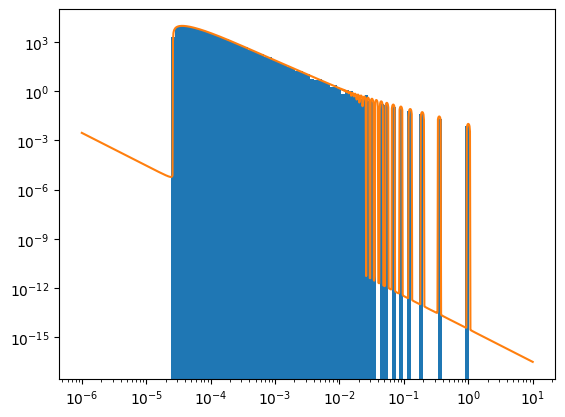

In [142]:
Khat_eigs = model.empirical_spectrum(n_sims=5)
plot_spectra(Khat_eigs,limit_dist)